## Feature Engineering

- [TFIDF Vectorization](#tfidf)
- [Lemmatization](#lemmize)
- [Train Test Split](#split)
- [Rescaling](#rescale)
- [Principal Component Analysis](#pca)

### Import Necessary Modules and Datasets

In [1]:
# Import tools to get datasets
from io import BytesIO
from zipfile import ZipFile
import urllib

# Import data manipulation and plot modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import NLP and ML tools
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# Unzip and read Average Q
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_average_score_data.zip')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("neat_average_score_data")
q = pd.read_json(qfile, encoding='cp1252')
file.close()

### TFIDF Vectorization <a id='tfidf'></a> 

In [3]:
def vectorize_df(data, column, stop_words = None, max_df = 1, min_df = 1):
    
    # Use TfidVectorizer to vectorize selected column
    vectorizer = TfidfVectorizer(stop_words = stop_words, max_df = max_df, min_df = min_df)
    vectorized_array = vectorizer.fit_transform(data[column]).toarray()
    names_list = vectorizer.get_feature_names()
    
    # Datafy vectorized matrix and create empty dictionary list
    df = pd.DataFrame(vectorized_array.tolist())
    columns_renamed = {}
    
    # Automate to replace all column names
    for i in enumerate(names_list):
        columns_renamed[i[0]] = i[1]
    df = df.rename(columns = columns_renamed)
    
    # Merge data with df
    the_data = data.merge(df, left_index = True,
                              right_index = True,
                              how = 'inner')
    
    return the_data

In [4]:
# Fix the index sequence due to some missing sequences that affect further feature engineering
q = q.set_index(np.arange(0,len(q)))

# Select Average Score and Measure Description columns
q_selected = q[['Four Quarter Average Score','Measure Description']]

# Vectorize and Drop Measure Description
cleaned_q = vectorize_df(q_selected,'Measure Description', stop_words = 'english', 
                         max_df = 0.8, min_df = 2).drop('Measure Description', axis = 1)

### Lemmatization <a id='lemmize'></a>

In [5]:
### Before Lemmatization 
pre_lemmatize = len(list(cleaned_q.columns))

lemmatizer = WordNetLemmatizer()

thelist = []
for i in range(0,len(list(cleaned_q.columns))):
    word = lemmatizer.lemmatize(list(cleaned_q.columns)[i],pos='v')
    thelist.append(word)

# After Lemmatization
post_lemmatize = len(set(thelist))

print(pre_lemmatize > post_lemmatize)

False


Lemmatization does not help reduce the dimension, so it won't be applied.

### Train Test Split <a id = 'split'></a>

In [6]:
# Split test and train to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(cleaned_q.drop('Four Quarter Average Score',axis = 1),
                                                   cleaned_q[['Four Quarter Average Score']],
                                                   test_size=.40, random_state = 42)

In [7]:
# Split test and train to prevent data leakage
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,test_size=.50,
                                                   random_state = 42)

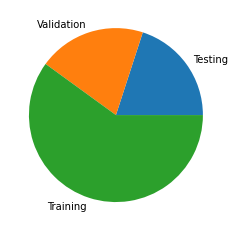

In [8]:
plt.pie([len(X_test),len(X_valid),len(X_train)],  labels=['Testing','Validation','Training'])
plt.show()

### Rescaling <a id='rescale'></a>

In [9]:
# 100-0 to 1-0 using transform function: x/100
def transform(target):
    target = target/100
    return target

y_train = transform(y_train)
y_test = transform(y_test)
y_valid = transform(y_valid)

In [10]:
# Save TDFIDF X datasets
X_train.to_csv("downloads/X_TFIDF_train")
X_valid.to_csv("downloads/X_TFIDF_valid")
X_test.to_csv("downloads/X_TFIDF_test")

FileNotFoundError: [Errno 2] No such file or directory: 'downloads/X_TFIDF_train'

### Principal Component Analysis <a id='pca'></a>

In [ ]:
PCA(X_train)

In [ ]:
# Sum all inputs for each row 
X_train['sum']= X_train.sum(axis=1)

# Median, Mean, Minimum, Maximum, and Standard Deviation Angles 
median_angle = X_train[X_train['sum'] == np.median(X_train['sum'])].drop('sum',axis=1).head(1)
mean_angle = pd.DataFrame(X_train.mean()).T.drop('sum',axis=1)
minimum_angle = X_train[X_train['sum'] == np.min(X_train['sum'])].drop('sum',axis=1).head(1)
maximum_angle = X_train[X_train['sum'] == np.max(X_train['sum'])].drop('sum',axis=1).head(1)
std_angle = pd.DataFrame(X_train.std()).T.drop('sum',axis=1)

In [ ]:
cos_similarities = pd.concat([median_angle,mean_angle,minimum_angle,maximum_angle,
                              std_angle])

In [ ]:
# Remove X_train's sum column
X_train = X_train.drop('sum',axis=1)
renames = {0:'cosine median',1:'cosine mean', 2:'cosine minimum',3:'cosine maximum',4:'cosine std'}

# Transform from the Cosine Similarity Fit
X_train = pd.DataFrame(cosine_similarity(X_train, cos_similarities)).rename(columns=renames)
X_valid = pd.DataFrame(cosine_similarity(X_valid, cos_similarities)).rename(columns=renames)
X_test = pd.DataFrame(cosine_similarity(X_test, cos_similarities)).rename(columns=renames)

In [ ]:
print(y_train[0:5])

In [ ]:
display(X_train.head(5))

In [ ]:
# Save X datasets
#X_train.to_csv("downloads/X_train")
#X_valid.to_csv("downloads/X_valid")
#X_test.to_csv("downloads/X_test")
#
## Save y datasets
#with open('downloads/y_train', 'wb') as f:
#    np.save(f, y_train)
#with open('downloads/y_valid', 'wb') as f:
#    np.save(f, y_valid)
#with open('downloads/y_test', 'wb') as f:
#    np.save(f, y_test)